<a href="https://colab.research.google.com/github/patriglesias/patriglesias/blob/main/MLproject_Patricia__Iglesias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


The goal of this project is to perform simulation based inference with deep learning to constrain cosmological parameters. We will use the [CAMELS project](https://www.camel-simulations.org/). The Cosmology and Astrophysics with Machine Learning Simulations (CAMELS) is a suite of cosmological simulations with varying comsologies and subgrid physics, specially desgined for training Machine Learnning models. 

For this exercise we are going to use the [Multifield dataset](https://camels-multifield-dataset.readthedocs.io/en/latest/), which consists of a series of 2D Maps of different quantities (Stellar Mass, Total Mass, Gas Temperature, Velocity ...) for different cosmologies and subgrid parameters. 


# Connect to GCloud

Just run these cells. Do not modify.

In [1]:
from google.colab import auth
auth.authenticate_user()

In [2]:
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0   103k      0 --:--:-- --:--:-- --:--:--  103k
OK
47 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 47 not upgraded.
Need to get 11.5 MB of archives.
After this operation, 27.2 MB of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 155629 files and directories currently installed.)
Preparing to unpack .../gcsfuse_0.41.1_amd64.deb ...
Unpacking gcsfuse (0.41.1) ...
Setting up gcsfuse (0.41.1) ...


In [3]:
!mkdir -p data
!gcsfuse --implicit-dirs -o allow_other -file-mode=777 -dir-mode=777 camels data


2022/05/21 15:05:55.306592 Start gcsfuse/0.41.1 (Go version go1.17.6) for app "" using mount point: /content/data
2022/05/21 15:05:55.319547 Opening GCS connection...
2022/05/21 15:05:55.740065 Mounting file system "camels"...
2022/05/21 15:05:55.781064 File system has been successfully mounted.


# Import python modules

In [4]:
import numpy as np
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
import tensorflow as tf
import tensorflow_probability as tfp
import sklearn

tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers
plt.style.use(astropy_mpl_style)
print(tfp.__version__)

0.16.0


#Load Maps and Corresponding parameters
The maps can be changed.

The models can be: 
 - IllustrisTNG
 -  SIMBA

The map types can be:
-  T (Gas Temperature)
-  Mstar (stellar mass)
- Z (Metallicity) 
-  Mgas (Gas Mass)
- Vgas (Gas Velocity)
- Mtot (total mass) etc..

The list of available files is in /content/data

In [5]:
# This function loads the maps and corresponding parameters

def load_maps(model,maptype):

  fmaps = '/content/data/Maps_'+maptype+'_'+model+'_LH_z=0.00.npy'
  maps  = np.load(fmaps)
  fparams = '/content/data/params_'+model+'.txt'
  params  = np.loadtxt(fparams)
  return maps,params

  

In [8]:
# loads the temperature map of Illustris TNG - can take a while
maps, params = load_maps('IllustrisTNG','T')

The following cell shows a random example of the loaded map together with the corresponding parameters. You can run it several times. The goal is to design a deep learning model to infer cosmological and astrophysical parameters using the different maps. We will also check the maps have uniform values of $\Omega_m$ between 0.1 and 0.5.

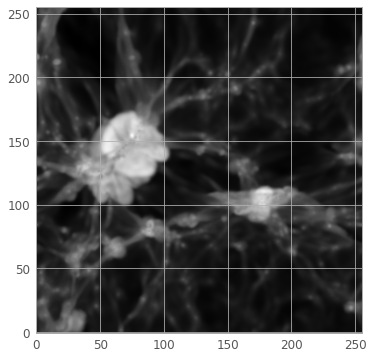

Value of the parameters for this map
Omega_m: 0.49380
sigma_8: 0.70820
A_SN1:   1.93187
A_AGN1:  0.25104
A_SN2:   0.56058
A_AGN2:  0.72247


Text(0, 0.5, 'N')

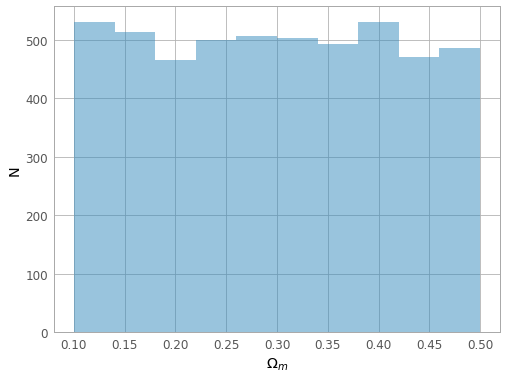

In [9]:
from random import randrange
from random import sample

index=sample(range(np.shape(maps)[0]),5000) #we just work with 5000 maps (avoid memory problems)


omegas=[]
for i in range(len(maps)):
  omega=params[i//15]
  omegas.append(omega[0]) #we just save the dark matter density

omegas=np.array(omegas)[index]
maps=maps[index,:,:] 
N,nrows,ncols=np.shape(maps)



map_number = randrange(np.shape(maps)[0])
plt.imshow(np.log10(maps[map_number]),cmap=plt.get_cmap('binary_r'), origin='lower', interpolation='bicubic')
plt.show()
params_map = params[map_number//15] ## This is how params and maps are connected. 
print('Value of the parameters for this map')
print('Omega_m: %.5f'%params_map[0])
print('sigma_8: %.5f'%params_map[1])
print('A_SN1:   %.5f'%params_map[2])
print('A_AGN1:  %.5f'%params_map[3])
print('A_SN2:   %.5f'%params_map[4])
print('A_AGN2:  %.5f'%params_map[5])




plt.hist(omegas,alpha=0.5) #we check that our maps have uniformly distributed dark matter densities
plt.xlabel('$\\Omega_m$')  #that is, we have a balanced dataset
plt.ylabel('N')

# Exercise 1: 
Create a Convolutional Neural Network that takes the map of gas temperature (T) from the IllustrisTNG model as input, and estimates $\Omega_m$ (the Dark Matter Density). The output of the Neural Network should be a Gaussian Probability Density Function. 

We will produce:
- A brief summary of the architecture used.
- A plot of the learning history including the training and the validation sets
- A plot of input vs. output on the test set, including error bars. You will use the mean of the PDF as output. 
- Ten example plots of PDFs, together with the ground truth.
- 1-sigma value of the PDF versus the true error for the test set. Does the PDF properly capture uncertainty? Comment briefly.



## Preprocessing - Normalization

Most of the machine learning models require the normalization of the input datasets, to avoid the model learning according to the number of counts (in an image for example), if we are looking for other features. We have trained the model with and without a previous normalization of the maps, and we have found that the performance improves without. We conclude that somehow the dark matter density depends on the exact values of temperature, and not just on its distribution.

In [10]:
#The normalization of the data affects negatively to the performance of the model

def norm(x): 
  #for i in range(len(x[:,0,0])):
  #    x[i,:,:]=x[i,:,:]/np.max(x[i,:,:])
  return x 



## Split in training, validation and test datasets.


To continue we will divide the $5000$ maps of IllustrisTNG, and their corresponding dark matter densities, in three datasets:



*   Training dataset: the sample of data used to fit the model.
*   Validation dataset: the sample used to provide an unbiased evaluation of a model fit on the training dataset while tuning model weights (helps during the development stage of the model).
*   Test dataset: the sample used to provide an unbiased evaluation of a final model.

In this case we will use $8/10$ of the maps for training, $1/10$ for validation, and $1/10$ for testing. The shapes of the arrays that include the maps $(X)$ are $(4000, 256, 256)$, $(500, 256, 256)$ and $(500, 256, 256)$, respectively, as each map has a size $(256,256)$. On the other hand, the density arrays $(Y)$ have just one dimension, $(4000)$,  $(500)$ and $(500)$ for the three different datasets.

In [11]:
# function to generate training, validation and test sets. Takes as input parameters
# the sizes of the differnet datasets. 

def train_test(ntrain,nval,ntest):
  Y=[]
  for i in range(maps.shape[0]):
    Y.append(omegas[i])
  X, Y = sklearn.utils.shuffle(maps, Y)
  Xtrain=X[0:ntrain]
  Ytrain = Y[0:ntrain]

  Xval = X[ntrain:ntrain+nval]
  Yval = Y[ntrain:ntrain+nval]

  Xtest = X[ntrain+nval:ntrain+nval+ntest]
  Ytest = Y[ntrain+nval:ntrain+nval+ntest]
  return np.array(norm(Xtrain)),np.array(Ytrain),np.array(norm(Xval)),np.array(Yval),np.array(norm(Xtest)),np.array(Ytest)

xtrain,ytrain,xval,yval,xtest,ytest=train_test(int(8/10*N),int(1/10*N),int(1/10*N))

print(np.shape(xtrain),np.shape(xval),np.shape(xtest))
print(np.shape(ytrain),np.shape(yval),np.shape(ytest))

(4000, 256, 256) (500, 256, 256) (500, 256, 256)
(4000,) (500,) (500,)


# Model architecture and compilation

We are now going to build our model. It should include convolutional layers, as well as return a gaussian probability distribution.

It consists in:

-Convolutional part:

* Three convolutional layers: they extract the characteristic features of an image/map by applying filters (kernels). These are generated by initializers which seek not to have elements (weights) that are too small or large (worse for learning). The set of matrices resulting from convolving the images by the kernels are the feature maps. Once a feature map is created, we can pass each of its values through a nonlinearity, such as ReLU. This is a very simple activation function: $f(x)=\max (0, x)$, commonly used in DL. It helps to prevent vanishing/exploding gradients (training unstable, very slow, or no convergent).

* Two batch normalization layers: they are used to make the network faster and more stable through normalization of the layers' inputs by re-centering and re-scaling. They also help to prevent vanishing/exploding gradients.
 

* One MaxPooling: it extracts the most representative pixels from a delimited strip of an image (in this case the maximum values). It is an operation of downsampling used to reduce the overall size of tensors.


-Fully connected part:

* One flatten layer: it combines all the  feature maps into a $1D$ array, to be processed by traditional (fully connected) layers of neurons.

* Two dense layers: also called fully connected layers. The neurons on it have connections to all activations in the previous layer. In these connections, the output value of the previous neuron is multiplied by a weight value. These bond weights can increase or inhibit the activation state of adjacent neurons. To obtain the ideal ones, an attempt is made to minimize a loss function that evaluates the network as a whole. The values of the weights of the neurons are updated seeking to reduce the value of the loss function using an optimizer. This process is called **backpropagation**.

* One dropout layer: as relatively small datasets can overfit the training data, which results in poor performance when the model is evaluated on new data, some layer outputs are randomly ignored or 'dropped out' ($25\%$ of the neurons in this case).


-Output layers:

To quantify the uncertainty in the predictions, we write the  model as $P(y | x, w)$, the probability distribution of labels $(y)$, given the inputs $(x)$ and some parameters $(w)$. We will fit the model  by maximizing the probability of the labels, or equivalently, minimizing the negative log-likelihood loss: $-log P(y | x)$. In particular, the two last layers of our models will guarantee we receive for each map a gaussian distribution.

We have mentioned already we will use the negative log-likelihood loss. On the other hand, we will use Adam optimizer.

In [6]:
def cnn(img_rows, img_cols):
    
    #Hyperparameters
    dropoutpar=0.25
    depth=64   
    units = 64
    
    #Convolutional layers
    inputs = tfkl.Input(shape=(img_rows, img_cols,1))
    x=tfkl.Conv2D(depth, (6,6) ,6,activation='relu',padding='same',name='conv1')(inputs)
    x=tfkl.BatchNormalization()(x)  # batch normalization layer
    x=tfkl.Conv2D(depth/2, (4,4), 4, activation='relu',padding='same',name='conv2')(x)
    x=tfkl.MaxPool2D(pool_size=(2,2))(x) #pooling layer
    x=tfkl.Conv2D(depth/2, (4,4), 1, activation='relu',padding='same',name='conv3')(x)
    x=tfkl.MaxPool2D(pool_size=(2,2))(x)
    x=tfkl.BatchNormalization()(x)
    
    #Fully connected layers
    x=tfkl.Flatten()(x)
    x=tfkl.Dense(units, activation='relu',name='dense1')(x)
    x=tfkl.Dense(units/2, activation='relu',name='dense2')(x)
    x=tfkl.Dropout(dropoutpar)(x)

    #Output layer, it produces a pdf
    x=tfkl.Dense(tfpl.IndependentNormal.params_size(1),activation=None)(x)
    x=tfpl.IndependentNormal(1, tfd.Normal.sample)(x)
    
    #We build the model
    model = tfk.Model(inputs=inputs,outputs=x)

    #Compilation of the model
    print("Compilation...")
    negloglik = lambda y, rv_y: -rv_y.log_prob(y) #Calculates the log-likelihood multiplied by negative one
    model.compile(loss=negloglik,optimizer='adam')
    print("... done!")
    print("Model Summary")
    print("===================")
    model.summary()
    return model


# Train

We produce a summary of our model. It includes not only the layers we use, but also the shapes of the tensors after getting through them, as well as the number of trainable parameters.

In the next cell, we create two callbacks. They are used to monitor internal states and statistics of the model during training. In particular, we use an EarlyStopping and a ModelCheckpoint. While the first one allows stopping the training if the validation loss shows no improvement during $10$ epochs (patience=$10$), the ModelCheckpoint saves the model as a checkpoint file (in hdf5 format) to disk after getting a better value for the validation loss (or any other metric) during the training.

On the other hand, we produce augmentations of the maps (like rotation, zoom, flips and shifts), with ImageDataGenerator. However, we do not apply them in the definitive model because the performance did not improve significantly, but it increased a lot the duration of training.

We select a number of epochs, $30$, which shows a proper balance between time and performance (larger numbers do not decrease more the validation loss), and a batchsize, which corresponds to the number of maps  that are propagated  together through the network, equal to $64$. It is important to note that a larger batchsize implies more memory and time, but typically a more accurate error gradient.

Finally, we save the history of the model train and its weights in hdf5 format.


In [13]:
#build model
model=cnn(nrows,ncols)


Compilation...
... done!
Model Summary
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv1 (Conv2D)              (None, 43, 43, 64)        2368      
                                                                 
 batch_normalization (BatchN  (None, 43, 43, 64)       256       
 ormalization)                                                   
                                                                 
 conv2 (Conv2D)              (None, 11, 11, 32)        32800     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 5, 5, 32)         0         
 )                                                               
                                                                 
 conv3 (Conv2D)       

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

pathout=''
model_name='cnn'
patience_par=10
earlystopping = EarlyStopping(monitor='val_loss',patience = patience_par,verbose=0,mode='auto' )
modelcheckpoint = ModelCheckpoint(pathout+model_name+".hdf5",monitor='val_loss',verbose=0,save_best_only=True)


datagen = ImageDataGenerator( #remember cnn are traslation invariant, but not rotational invariant
            rotation_range=25,
            width_shift_range=0.1,  
            height_shift_range=0.1, 
            horizontal_flip=True,
            vertical_flip=True,
            zoom_range=[0.75,1.3])  

if len(np.shape(xtrain))==3:
  xtrain=np.expand_dims(xtrain, axis=3)

#datagen.fit(xtrain)
#history = model.fit(datagen.flow(xtrain, ytrain, batch_size=128),epochs=30,validation_data=(xval,yval),callbacks=[earlystopping,modelcheckpoint])
history = model.fit(xtrain, ytrain, batch_size=64,epochs=30,validation_data=(xval,yval),callbacks=[earlystopping,modelcheckpoint])
print("Saving model...")
model.save_weights(pathout+model_name+".hdf5",overwrite=True)

Epoch 1/30
63/63 [==============================] - 5s 49ms/step - loss: 1.1696 - val_loss: 1.4465
Epoch 2/30
63/63 [==============================] - 1s 22ms/step - loss: 0.3693 - val_loss: 0.5031
Epoch 3/30
63/63 [==============================] - 1s 21ms/step - loss: 0.0966 - val_loss: 0.0626
Epoch 4/30
63/63 [==============================] - 1s 20ms/step - loss: 0.0190 - val_loss: -0.3185
Epoch 5/30
63/63 [==============================] - 1s 21ms/step - loss: -0.1850 - val_loss: -0.4401
Epoch 6/30
63/63 [==============================] - 1s 20ms/step - loss: -0.3378 - val_loss: -0.6437
Epoch 7/30
63/63 [==============================] - 1s 21ms/step - loss: -0.5142 - val_loss: -0.6739
Epoch 8/30
63/63 [==============================] - 1s 21ms/step - loss: -0.6187 - val_loss: -0.7391
Epoch 9/30
63/63 [==============================] - 1s 20ms/step - loss: -0.5124 - val_loss: -0.2805
Epoch 10/30
63/63 [==============================] - 1s 21ms/step - loss: -0.4465 - val_loss: -0.5

#We check the evolution of the loss with the epochs

We show in the figure the evolution of the loss and of the validation loss as a function of the epochs for our model. We observe a good performance, as both curves decrease together up to a final value of $-1.2$ approximately. On the other hand, we have confirmed our choice of $30$ epochs, if we increase the number then the validation loss keeps constant or even starts increasing, while the loss (of the training set) decreases. This is a problem known as overfitting, as we mentioned before, and takes place when the model learns the training set perfectly, but without any generalization ability. 



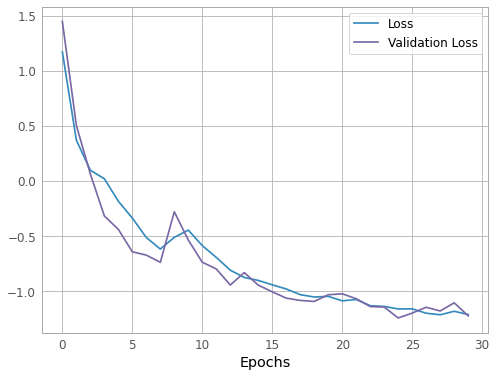

In [ ]:
plt.plot(np.arange(len(history.history['loss'])),history.history['loss'],label='Loss')
plt.plot(np.arange(len(history.history['loss'])),history.history['val_loss'],label='Validation Loss')
plt.xlabel('Epochs')
plt.legend()

#We evaluate our model using the test dataset


To evaluate the performance of the model with the test dataset, not shown during the training, we get the probability outputs for the dark matter density passing the test maps through the network. We work with their means and  standard deviations.

First of all, we check the mean values obtained with a histogram. We see that while the true values are uniformly distributed between 0.1-0.5, the predicted values are more concentrated in the middle of the interval, $\Omega_m=0.3$. 

On the other hand, we plot the values in the plane $\Omega_m^{true}$ - $\Omega_m^{predicted}$. We do a linear fit and we observe the slope of the line is slightly smaller than the line corresponding to a perfect model ($\Omega_m^{true}$ = $\Omega_m^{predicted}$). However, if we plot as error bars the standard deviation, we observe they are large enough to include that line too.

Then, we have selected ten random maps and we plot their predicted gaussian distributions for the dark matter density, together with the true values of $\Omega_m$ in the legend. We observe how the network does not predict properly the density of the maps whose $\Omega_m^{true}$ is very small/large, as it tends to predict values closer to $0.3$. However, it respects the order: small densities are assigned to maps with small  densities, and the same with large ones.

Finally, we have plotted the data points in a $\sigma$ - $ |y_{true}-y_{pred}|$ map, trying to find a relation between the standard deviation of the output probability and its actual error. We conclude that there is a positive correlation between them, that we show as the linear fit on green, so the probability output, and in general the Bayesian convolutional neural networks are a useful tool to evaluate uncertainties, as it is typically needed in scientific and astrophysics contexts.

(500, 1)
(500, 1)
(500, 1)


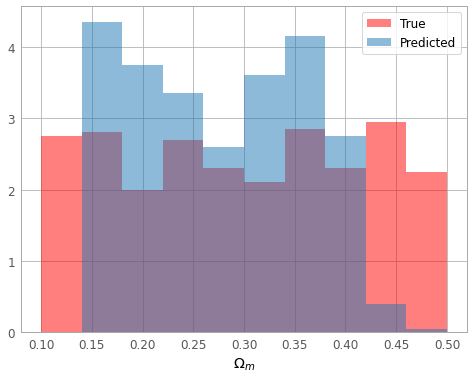

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.


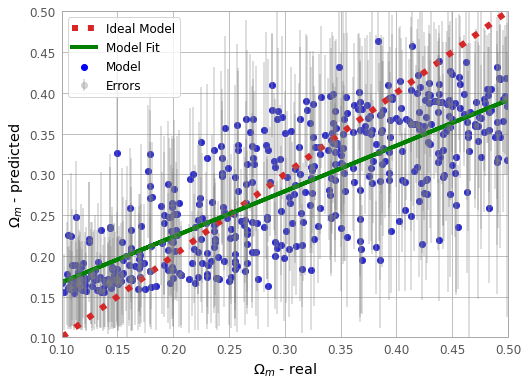

In [ ]:
#Prediction of a pdf for each map in xtest
ypred=model(xtest) 
mean=np.reshape(ypred.mean(),(500,))
std=np.reshape(ypred.stddev(),(500,))
ytest=np.reshape(ytest,(500,))


#Histogram. Any bias?
plt.hist(ytest,label='True',range=(0.1,0.5),alpha=0.5,density=True,bins=10,stacked=True,color='r')
plt.hist(mean,label='Predicted',range=(0.1,0.5),alpha=0.5,density=True,bins=10,stacked=True,color='tab:blue')
plt.xlabel('$\\Omega_m$')
plt.legend()
plt.show()

#Scatter plot with errors. Any bias?
plt.errorbar(ytest,mean,yerr=ypred.stddev(),color='grey',alpha=0.3,fmt='o',label='Errors')
plt.scatter(ytest,mean,color='b',marker='o',label='Model')
diag=np.linspace(np.min(ytest),np.max(ytest),1000)
plt.plot(diag,diag,':',lw=6,color='tab:red',label='Ideal Model')
p=np.polyfit(ytest,mean,1)
plt.plot(ytest,p[1]+p[0]*ytest,'g',lw=4,label='Model Fit')
plt.xlabel('$\\Omega_m$ - real')
plt.ylabel('$\\Omega_m$ - predicted')
plt.xlim(0.1,0.5)
plt.ylim(0.1,0.5)
plt.legend()

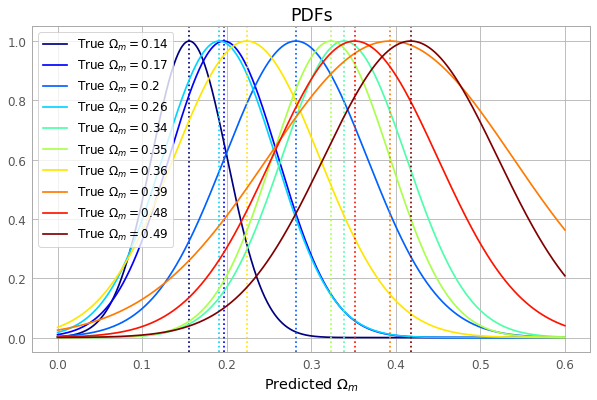

In [ ]:
from scipy import stats

plt.figure(figsize=(10,6))
x=np.linspace(0,0.6,1000)
#colors=['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']
colors=plt.cm.jet(np.linspace(0,1,10))
j=0
lista=sample(range(len(mean)),10)
ind=np.argsort(ytest[lista])



for i in np.array(lista)[ind]:
  normal = stats.norm(mean[i], std[i]).pdf(x) # PDF
  plt.plot(x, normal/np.max(np.array(normal)), label='True $\Omega_m = $'+str(round(ytest[i],2)),color=colors[j])
  plt.axvline(mean[i],color=colors[j],ls=':')
  j+=1

plt.title('PDFs')
plt.xlabel('Predicted $\Omega_m$')
plt.legend()
plt.show()


(500, 1)


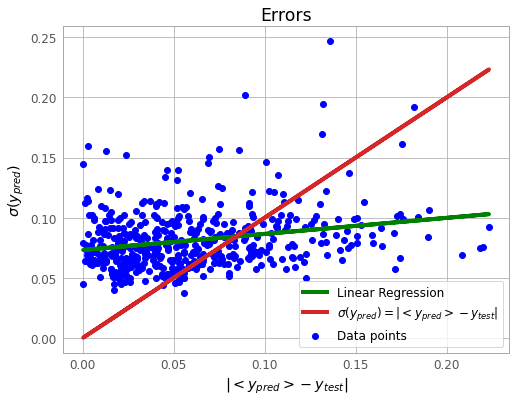

In [ ]:
error=np.abs(mean-ytest)
print(np.shape(error))
plt.scatter(error,std,marker='o',c='b',label='Data points')
plt.xlabel('$|{<{y_{pred}}>-y_{test}}|$')
plt.ylabel('$\\sigma(y_{pred})$')
p=np.polyfit(error,std,1)
plt.plot(error,error*p[0]+p[1],'g',lw=4,label='Linear Regression')
plt.plot(error,error,color='tab:red',ls='-',lw=4,label='$\\sigma(y_{pred})=|{<{y_{pred}}>-y_{test}}|$')
print('$\\sigma(y_{pred})='+str(round(p[1],2))+'+'+str(round(p[0],2))+'|{<{y_{pred}}>-y_{test}}|$')
plt.xlim(0,0.25)
plt.ylim(0,0.25)
plt.title('Errors')
plt.legend()

# Before starting Exercise 2: 
Please restart the kernel and excecute the first five cells, together with the one in which we build the model.

# Exercise 2:
Test the deep learning model on the same map, produced now with the SIMBA cosmological model. 

- Produce a scatter plot, including error bars, of input Omega_m versus output Omega_m. Comment.
- Plot ten example plots of probability distributions
- Plot the 1-sigma value of the posterior versus the true error. Does the posterior properly capture uncertainty? Comment.

We load the weights of the model we trained before.

In [8]:
nrows=256
ncols=256
pathout=''
model_name='cnn'
model=cnn(nrows,ncols)
model.load_weights(pathout+model_name+".hdf5") #we load the weights of the model we trained before

Compilation...
... done!
Model Summary
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv1 (Conv2D)              (None, 43, 43, 64)        2368      
                                                                 
 batch_normalization_2 (Batc  (None, 43, 43, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2 (Conv2D)              (None, 11, 11, 32)        32800     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 conv3 (Conv2D)     


We load the temperature map of SIMBA, and their corresponding dark matter densities. We restrict our analysis to 2000 maps.

In [9]:
maps, params = load_maps('SIMBA','T')
print(np.shape(maps))
Y=[]
for i in range(maps.shape[0]):
    Y.append(params[i//15][0])
X, Y = sklearn.utils.shuffle(maps, Y)

(15000, 256, 256)


In [13]:
from random import sample #we have imported these modules before, but just in case you have 
from scipy import stats   #not run them to save memory

index=sample(range(np.shape(X)[0]),2000)
Ypred=model(X[index,:,:])
Y=np.array(Y)[index]

## Analysis of the model in a dataset obtained from a different simulation

Once again we observe the distribution of the dark matter densities (true and predicted), in a histogram. While the true densities are uniformly distributed, the predicted ones are asymmetrical, larger than they should.

This result is also obtained in the plane $\Omega_m^{true}$ - $\Omega_m^{pred}$, where we have plotted the linear fit of the data $\pm$ the averaged standard deviations, checking that the perfect model is only included in the uncertainty for large values of the density.

However, the PDFs conserve their order (large means are predicted for large true dark matter density values), as it occurs with IllustrisTNG.

Finally, the standard deviations of the output distributions do not correlate positively with the actual deviation of the mean from the true value. We see that the performance of this model in this dataset is not good enough.

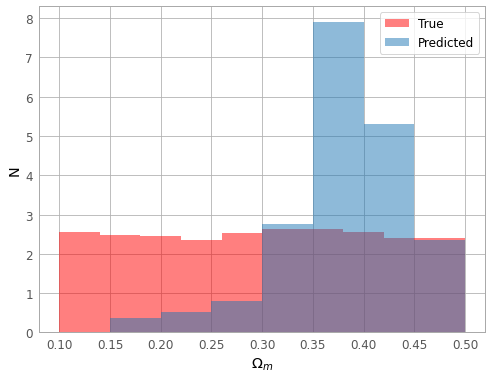

63


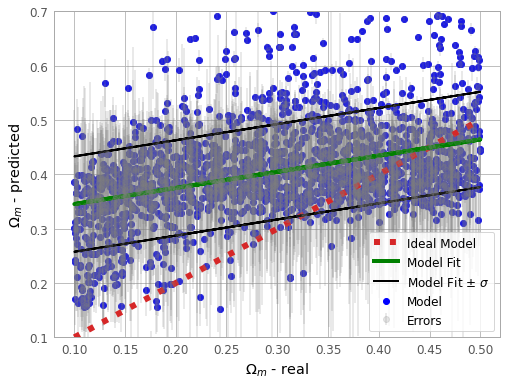

In [26]:

#Histogram. Any bias?
plt.hist(Y,range=(0.1,0.5),label='True',alpha=0.5,density=True,bins=10,stacked=True,color='r')
plt.hist(np.concatenate(Ypred.mean()),range=(0.1,0.5),label='Predicted',alpha=0.5,density=True,bins=8,stacked=True,color='tab:blue')
plt.xlabel('$\\Omega_m$')
plt.ylabel('N')
plt.legend()
plt.show()

#A small fraction of predicted values is very bad, we avoid it
index=np.where((Ypred.mean()>0.7) | (Ypred.mean()< -0.2) )[0]
print(len(index))
Ytrue=np.array(Y)
Ytrue=np.delete(Ytrue,index)
mean=np.delete(Ypred.mean(),index)
std=np.delete(Ypred.stddev(),index)

#Scatter plot with errors. Any bias?

plt.errorbar(Ytrue,mean,yerr=std,color='grey',alpha=0.2,fmt='o',label='Errors')
plt.scatter(Ytrue,mean,color='b',marker='o',label='Model')
diag=np.linspace(np.min(Ytrue),np.max(Ytrue),1000)
plt.plot(diag,diag,':',lw=6,color='tab:red',label='Ideal Model')
p=np.polyfit(Ytrue,mean,1)
plt.plot(Ytrue,p[1]+p[0]*Ytrue,'g',lw=4,label='Model Fit')
plt.plot(Ytrue,p[1]+p[0]*Ytrue+np.median(std),'k',lw=2,label='Model Fit $\\pm$ $\\sigma$')
plt.plot(Ytrue,p[1]+p[0]*Ytrue-np.median(std),'k',lw=2)
plt.xlabel('$\\Omega_m$ - real')
plt.ylabel('$\\Omega_m$ - predicted')
plt.ylim(0.1,0.7)
plt.legend()

639


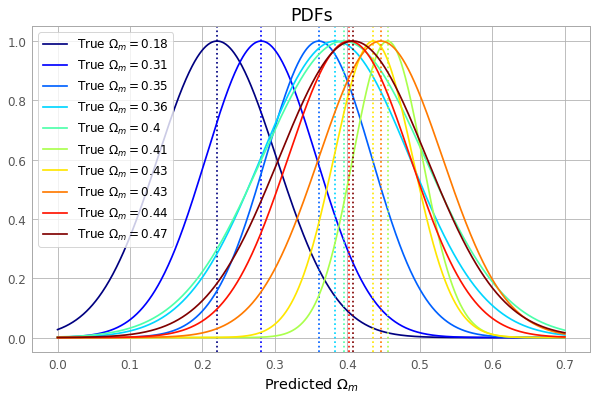

In [ ]:



plt.figure(figsize=(10,6))
x=np.linspace(0,0.7,1000)
#colors=['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']
colors=plt.cm.jet(np.linspace(0,1,10))
j=0
lista=sample(range(len(mean)),10)
ind=np.argsort(Ytrue[:][lista])



for i in np.array(lista)[ind]:
  normal = stats.norm(mean[i], std[i]).pdf(x) # PDF
  plt.plot(x, normal/np.max(np.array(normal)), label='True $\Omega_m = $'+str(round(Ytrue[i],2)),color=colors[j])
  plt.axvline(mean[i],color=colors[j],ls=':')
  j+=1

plt.title('PDFs')
plt.xlabel('Predicted $\Omega_m$')
plt.legend()
plt.show()


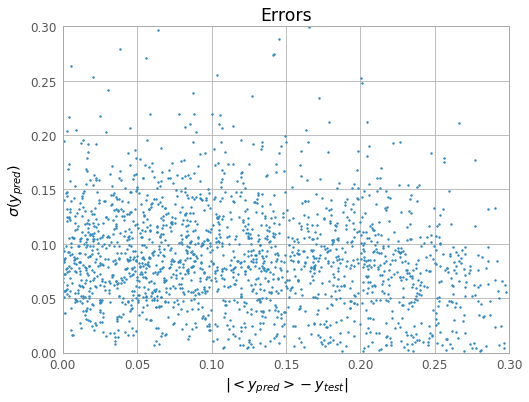

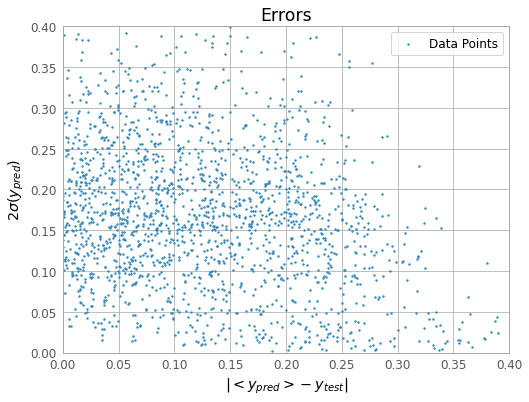

In [33]:

error=np.abs(mean-Ytrue)
plt.scatter(error,std,s=2, label='Data Points')
plt.xlabel('$|{<{y_{pred}}>-y_{test}}|$')
plt.ylabel('$\\sigma(y_{pred})$')
plt.xlim(0,0.3)
plt.ylim(0,0.3)
plt.title('Errors')
plt.show()


plt.scatter(error,2*std,s=2, label='Data Points')

plt.xlabel('$|{<{y_{pred}}>-y_{test}}|$')
plt.ylabel('$2 \\sigma(y_{pred})$')
plt.xlim(0,0.4)
plt.ylim(0,0.4)
plt.title('Errors')
plt.legend()
plt.show()

## Conclusions

The model could be improved, although it is on the right path, as it is indicated by the probability distributions, by having most of the averages ordered according to the real values ​​of the dark matter densities. However, to be useful at the astrophysical level, we need it to be generalizable to other simulations (or even to observations, in near future). This may require, although it does not allow the loss to drop so much during training,  a correct normalization and augmentation of the maps, such as those proposed in the previous cells. Even if it was finally decided not to carry them out, mostly because of GPU restrictions that did not allow to do as many trainings as we would like to, this should be incorporated as a continuation of the project. For example, if the network interprets that the density of dark matter is higher at higher temperatures, and then we introduce maps that generally have higher temperatures than those of the previous simulation, then it will tend to assign higher values ​​of the density to all the maps, without having into account the relative temperature differences between them.

